In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import gtsam.utils.plot as gtsam_plot
import cv2
import gtsam
import numpy as np
import math
import glob
import os
import itertools

Import Images

In [2]:
dir_name = '6Images/'
images_path = sorted( filter( os.path.isfile, glob.glob(dir_name + '*') ) )
images = [cv2.imread(file_path) for file_path in images_path]

Normalize the images

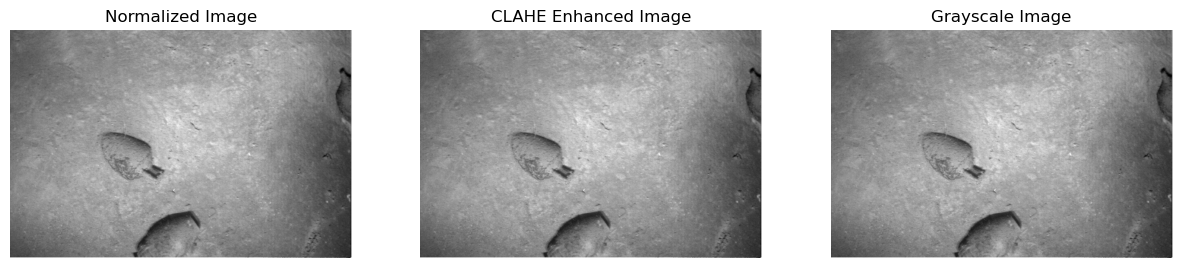

In [3]:
# image normalization
def normalize(images):
    normIm = []
    for img in images:
        norm_img = np.zeros(img.shape[:2])
        final_img = cv2.normalize(img,norm_img,0,255,cv2.NORM_MINMAX)
        normIm.append(final_img)
    return normIm

# Gray Conversion
def convertToGray(normIm):
    grayIm = []
    for img in normIm:
        gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grayIm.append(gr)
    return grayIm

# CLAHE image
def claheImages(img):
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
    for im in img:
        clahe.apply(im) + 30
    return img

normIm = normalize(images)

grayIm = convertToGray(normIm)
image_height, image_width = grayIm[0].shape

claheIm = claheImages(grayIm)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original normalized image
axes[0].imshow(normIm[0], cmap='gray')
axes[0].set_title('Normalized Image')
axes[0].axis('off') 
# CLAHE-enhanced image
axes[1].imshow(claheIm[0], cmap='gray')
axes[1].set_title('CLAHE Enhanced Image')
axes[1].axis('off') 
# Grayscale image
axes[2].imshow(grayIm[0], cmap='gray')
axes[2].set_title('Grayscale Image')
axes[2].axis('off') 
plt.show()

Create a Feature Detector to find features, and their descriptors

In [4]:
sift = cv2.SIFT_create(nfeatures=4000,nOctaveLayers=12,contrastThreshold=0.025,sigma=1.5)
def featureDetector(sift, grayIm):
    kp = []
    des = []
    outImages = []
    for im in grayIm:
        k, d = sift.detectAndCompute(im,None)
        outImage = cv2.drawKeypoints(im, k, im,color=[255,255,0],flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        kp.append(np.array(k))
        des.append(np.array(d))
        outImages.append(outImage)
        
    return kp, des, outImages
kp, des, outImages = featureDetector(sift, grayIm)

Used the Knn-match with lowe's filter from zernike, to segregate good matches

In [5]:
def knn_match_and_lowe_ratio_filter(matcher, des1, des2,threshold=0.90, dist_mask_12=None, draw_plot_dist=False):
    # First match 2 against 1
    if dist_mask_12 is None:
        dist_mask_21 = None
    else:
        dist_mask_21 = dist_mask_12.T
    matches_knn = matcher.knnMatch(des2,des1, k=2, mask = dist_mask_21 )
    all_ds = [m[0].distance for m in matches_knn if len(m) >0]

    #print("Len of knn matches", len(matches_knn))

    matches = []
    # Run lowes filter and filter with difference higher than threshold this might
    # still leave multiple matches into 1 (train descriptors)
    # Create mask of size des1 x des2 for permissible matches
    mask = np.zeros((des1.shape[0],des2.shape[0]),dtype='uint8')
    for match in matches_knn:
        if len(match)==1 or (len(match)>1 and match[0].distance < threshold*match[1].distance):
           # if match[0].distance < 75:
                matches.append(match[0])
                mask[match[0].trainIdx,match[0].queryIdx] = 1

    #matches = [m for m in matches if m.distance<5 ]

    if draw_plot_dist:
        fig, axes = plt.subplots(1, 1, num=3)
        filt_ds = [m.distance for m in matches]
        axes.plot(sorted(all_ds),'.',label = 'All Matches')
        axes.plot(sorted(filt_ds),'.',label = 'Filtered Matches')
        axes.set_xlabel('Number')
        axes.set_ylabel('Distance')
        axes.legend()
        plt.pause(.1)

    # run matches again using mask but from 1 to 2 which should remove duplicates
            # This is basically same as running cross match after lowe ratio test
    matches_cross = matcher.match(des1,des2,mask=mask)
    #print("Len of cross matches", len(matches_cross))
    return matches_cross

In [6]:
def Matches(kp, des, onlyImagePair=False):
    matcher  = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches  = []
    kp_match = [] 
    if onlyImagePair:
        matches.append(knn_match_and_lowe_ratio_filter(matcher,des[0],des[1],threshold=0.90))
        kp0_match_pts = np.array([kp[0][mat.queryIdx].pt for mat in matches[0]])
        kp1_match_pts = np.array([kp[1][mat.trainIdx].pt for mat in matches[0]])
        kp_match.append((kp0_match_pts,kp1_match_pts))
    else:
        # do sequential matching
        for i in range(len(kp)):
            if i < len(kp) - 1:
                # match with next pair
                matches.append(knn_match_and_lowe_ratio_filter(matcher,des[i],des[i+1],threshold=0.90))
                kp0_match_pts = np.array([kp[i][mat.queryIdx].pt for mat in matches[i]])
                kp1_match_pts = np.array([kp[i+1][mat.trainIdx].pt for mat in matches[i]])
            else:
                # if i is at last image index, match the last image with the first image
                matches.append(knn_match_and_lowe_ratio_filter(matcher,des[i],des[0],threshold=0.90))
                kp0_match_pts = np.array([kp[i][mat.queryIdx].pt for mat in matches[i]])
                kp1_match_pts = np.array([kp[0][mat.trainIdx].pt for mat in matches[i]])


            kp_match.append((kp0_match_pts,kp1_match_pts))
    return matches, kp_match
matches, kp_match = Matches(kp,des)

Function to find inliers from the keypoints segregated using lowe's filter

In [7]:
def Inliers(kp, matches, kp_match):
    mask = []       # List to store RANSAC masks
    inliers = []    # List to store inlier correspondences
    i = 0

    # Loop through the list of keypoint matches between pairs of images
    for k in kp_match:
        # Use cv2.findFundamentalMat to estimate the Fundamental Matrix (F) and obtain a mask of inliers
        F, maskMatch = cv2.findFundamentalMat(k[0], k[1], method=cv2.FM_RANSAC, ransacReprojThreshold=1.0, confidence=0.9999)
        
        mask.append(maskMatch)  # Append the RANSAC mask to the list

        # Extract inliers from the matches based on the RANSAC mask
        kp0_match_inliers = [kp[i][mat.queryIdx] for mat, msk in zip(matches[i], mask[i]) if msk]

        # Depending on the pair index 'i', choose the keypoints from the correct image
        if i < 5:
            kp1_match_inliers = [kp[i+1][mat.trainIdx] for mat, msk in zip(matches[i], mask[i]) if msk]
        else:
            kp1_match_inliers = [kp[0][mat.trainIdx] for mat, msk in zip(matches[i], mask[i]) if msk]

        # Store the inlier correspondences as pairs of keypoints
        inliers.append((kp0_match_inliers, kp1_match_inliers))
        i += 1  # Increment the pair index

    return inliers, mask
kp_match_inliers, inlier_mask = Inliers(kp, matches, kp_match)

Function to find Homography

In [8]:
def Homography(kp_match, inliers=True):
    global pts_left_src
    global pts_right_dst
    pts_left_src = []
    pts_right_dst = []
    h = []  # List to store homography matrices
    mask = []  # List to store RANSAC masks

    if inliers:
        # Extract keypoints from inlier matches
        for kp_match in kp_match_inliers:
            pts_left_src.append(np.float32([kp.pt for kp in kp_match[0]]))
            pts_right_dst.append(np.float32([kp.pt for kp in kp_match[1]]))
    else:
        # Extract keypoints from matches and perform RANSAC
        for kp_match in kp_match_inliers:
            pts_left_src.append(np.float32([kp.pt for kp in kp_match[0]]))
            pts_right_dst.append(np.float32([kp.pt for kp in kp_match[1]]))

    # Estimate homography for each pair of keypoints
    for i in range(len(pts_left_src)):
        if inliers:
            h_img, mask_img = cv2.findHomography(pts_right_dst[i], pts_left_src[i])
        else:
            h_img, mask_img = cv2.findHomography(pts_right_dst[i], pts_left_src[i], cv2.RANSAC, 1.0)
        h.append(h_img)
        mask.append(mask_img)

    return h, mask
h, mask = Homography(kp_match, inliers=False)

In [9]:
def isHomographyGood(h):
    hR = h[0:2,0:2]
    if np.linalg.det(hR) > 0:
        return True
    else:
        return False

In [10]:
def registerTwoImages(imgList, index1, index2, kp, des):
    # Get the grayscale images, keypoints, and descriptors for the two input indices
    keypoints = [kp[index1], kp[index2]]
    descriptors = [des[index1], des[index2]]
    
    # Find matches and inliers between the keypoints and descriptors
    matches, kp_match = Matches(keypoints, descriptors, onlyImagePair=True)
    
    # Compute homography for the keypoints match
    h, mask = Homography(kp_match, inliers=False)
    
    # Check if the computed homography is good
    if isHomographyGood(h[0]):
        # Warp the second image onto the first image
        return h, mask
    else:
        # If the homography is not good, return None
        return None, None


#todo, try kp_match_inliers

In [11]:
def ODOMETRY_NOISE(mask):
    numMatches = np.count_nonzero(mask)
    # define error lists in the form of [xerr,yerr,theta_err]
    minError = [0.2, 0.2, 0.1]
    smallError = [0.5, 0.5, 0.25]
    largeError = [0.8, 0.8, 0.4]
    maxError = [1.0, 1.0, 0.5]
    
    if numMatches > 100:
        err = minError
    elif numMatches > 50 and numMatches <= 100:
        err = smallError
    elif numMatches > 20 and numMatches <= 50:
        err = largeError
    else:
        # less than 20 inlier matches
        err = maxError
    
    return gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(err[0], err[1], err[2]))

In [12]:
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(0.3, 0.3, 0.1))
graph = gtsam.NonlinearFactorGraph()

# add a prior on the first pose at origin (image 0 center)
graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(image_width/2, image_height/2, 0), PRIOR_NOISE))

In [13]:
def getFactorPose(index, pts_src=pts_left_src, pts_dst=pts_right_dst):
    global ransac_mask

    # Use OpenCV's estimateAffinePartial2D to compute a similarity transform
    similarity_mat, ransac_mask = cv2.estimateAffinePartial2D(pts_dst[index], pts_src[index])

    # Compute the scale factor from the similarity transformation matrix
    scale = np.sqrt(similarity_mat[0, 0]**2 + similarity_mat[1, 0]**2)

    # Normalize the rotation matrix by dividing by the scale factor
    similarity_mat[:2, :2] /= scale

    # Create an affine matrix by adding a [0, 0, 1] row at the bottom, for homogenity
    affine_matrix = np.vstack((similarity_mat, [0, 0, 1]))

    # Calculate the pose from the affine matrix
    pose = gtsam.Pose2(affine_matrix[0, -1], affine_matrix[1, -1],
                       np.arctan2(affine_matrix[1, 0], affine_matrix[0, 0]))

    return pose
getFactorPose(0)

(-5.87132, 131.797, -0.021269)

In [14]:
def extractHomographyPose(h):
    # Copy the input homography matrix for modification
    affineEst = h.copy()

    # Set the third column of the matrix to [0, 0, 1] for affine transformation
    affineEst[2][0] = 0
    affineEst[2][1] = 0

    # Calculate the scale factor from the first column
    scale = np.sqrt(affineEst[0, 0]**2 + affineEst[1, 0]**2)

    # Normalize the rotation matrix by dividing by the scale factor
    affineEst[:2, :2] /= scale

    # Create a 3x3 transformation matrix with [0, 0, 1] at the bottom
    total_affine_matrix = np.eye(3)

    # Invert the homography matrix and set it as the affine transformation
    affineEst_inv = np.linalg.inv(affineEst)
    affineEst = affineEst_inv.dot(total_affine_matrix)

    # Extract translation and rotation components and create a Pose2 object
    pose = gtsam.Pose2(affineEst[0, -1], affineEst[1, -1],
                       np.arctan2(affineEst[1, 0], affineEst[0, 0]))

    return pose


In [15]:
def initialEstimates(h):
    # Create an empty container for initial estimates
    initial_estimate = gtsam.Values()

    # Insert an identity pose for the first image at index 0
    initial_estimate.insert(0, gtsam.Pose2())

    # Iterate through the homography matrices for the remaining images
    for i in range(len(h) - 1):
        # Extract a Pose2 estimate from the homography matrix & Insert the pose estimate into the initial estimates container
        initial_estimate.insert(i+1, extractHomographyPose(h[i]))

    return initial_estimate
initial = initialEstimates(h)

In [16]:
def plot_graph(initial, graph, marginals):
    # Create a dictionary to store image numbers
    image_numbers = {}

    # Iterate through each vertex (image pose) in the factor graph
    for node in range(initial.size()):
        # Plot the estimated pose with specified settings
        pose = initial.atPose2(node)
        gtsam_plot.plot_pose2(0, pose, 0.5, marginals.marginalCovariance(node))

        # Add image number annotation
        plt.annotate(f"Image {node}", (pose.x(), pose.y()), textcoords="offset points", xytext=(0, 10),
                     ha='center', fontsize=10, color='red')

        # Store the image number for later reference
        image_numbers[node] = pose

    # Iterate through each edge (connection between images) in the factor graph
    for edge in range(graph.size())[1:]:
        # Get the keys associated with the edge (connected vertices)
        start_key, end_key = graph.at(edge).keys()

        # Get the poses of the connected vertices (images)
        start_pose = image_numbers[start_key]
        end_pose = image_numbers[end_key]

        # Plot a line connecting the two image poses
        plt.plot([start_pose.x(), end_pose.x()], [start_pose.y(), end_pose.y()], color='blue')

    plt.axis('equal')
    plt.show()


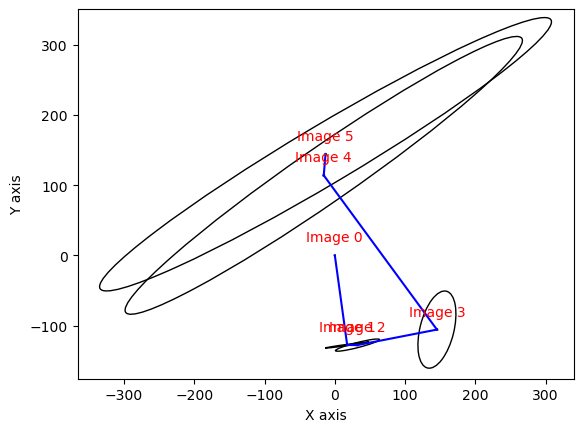

In [17]:
for src, dst in itertools.combinations(range(len(normIm)), 2):
    # Check if the indices represent consecutive images
    if src + 1 == dst:
        # Calculate the pose transformation between the source and destination images
        pose_transformation = getFactorPose(src)
        
        # Calculate the noise model for the pose transformation
        noise_model = ODOMETRY_NOISE(mask[src])
        
        # Add a factor representing the pose relationship between the images
        factor = gtsam.BetweenFactorPose2(src, dst, pose_transformation, noise_model)
        
        # Add the factor to the factor graph
        graph.add(factor)
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

In [18]:
for src, dst in itertools.combinations(range(len(normIm)), 2):
    if src + 1 != dst:

        match_overlap, kp_match_overlap = Matches([kp[src],kp[dst]], [des[src],des[dst]], onlyImagePair=True)
        homography, _ = Homography(kp_match_overlap, inliers = False)

        if homography is not None and isHomographyGood(homography[0]):

            pts_left_overlap  = []
            pts_right_overlap = []
            for kp_matches in kp_match_overlap:
                pts_left_overlap.append(np.float32([kp_matches[0][i] for i in range(len(kp_matches[0]))]))
                pts_right_overlap.append(np.float32([kp_matches[1][i] for i in range(len(kp_matches[1]))]))

            factor_pose = getFactorPose(0, pts_left_overlap, pts_right_overlap)
            if factor_pose is not None:
                graph.add(gtsam.BetweenFactorPose2(src, dst,
                                    factor_pose, ODOMETRY_NOISE(ransac_mask)))

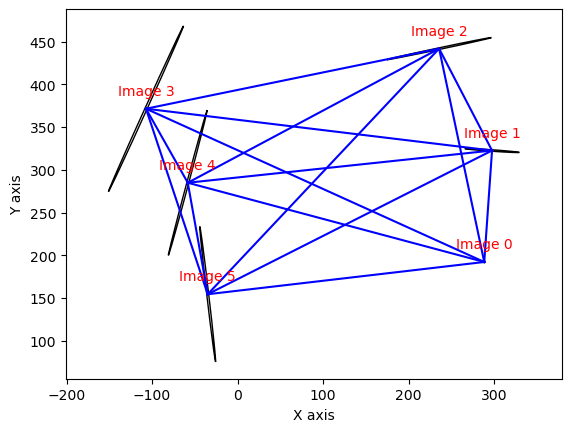

In [19]:
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
initial = optimizer.optimize()
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

In [20]:
marginals = gtsam.Marginals(graph, initial)
for i in range(1, 6):
    print("X{} covariance:\n{}\n".format(i, marginals.marginalCovariance(i)))

X1 covariance:
[[ 1.41022369e+02 -6.49212287e+01 -1.18697568e+00]
 [-6.49212287e+01  3.00392625e+01  5.47024862e-01]
 [-1.18697568e+00  5.47024862e-01  1.00021357e-02]]

X2 covariance:
[[ 6.23155649e+02 -1.31014060e+02 -2.49611305e+00]
 [-1.31014060e+02  2.76985240e+01  5.25023393e-01]
 [-2.49611305e+00  5.25023393e-01  1.00037806e-02]]

X3 covariance:
[[ 8.67517175e+02  9.40239719e+02 -2.94598172e+00]
 [ 9.40239719e+02  1.01962478e+03 -3.19304124e+00]
 [-2.94598172e+00 -3.19304124e+00  1.00085764e-02]]

X4 covariance:
[[ 1.49793388e+02  4.12708153e+02 -1.22361368e+00]
 [ 4.12708153e+02  1.13890004e+03 -3.37463020e+00]
 [-1.22361368e+00 -3.37463020e+00  1.00114064e-02]]

X5 covariance:
[[ 5.60144812e+00  7.53691097e+01 -2.31579886e-01]
 [ 7.53691097e+01  1.05521644e+03 -3.24823706e+00]
 [-2.31579886e-01 -3.24823706e+00  1.42435062e-02]]

